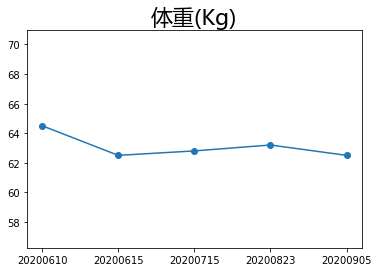

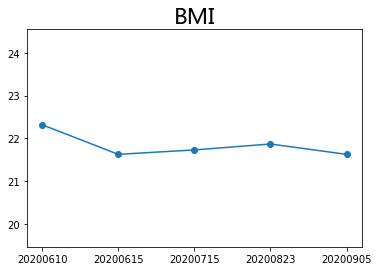

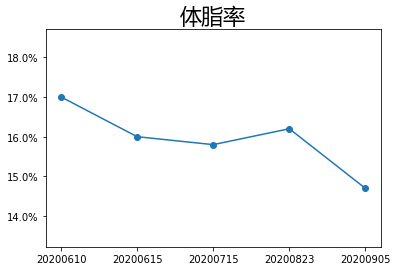

In [16]:
import sys
sys.path.append('../mypy/MyModel')
import os
import json
import datetime
import pandas as pd
import numpy as np
import days_calculate
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.font_manager as fm


class Customs:
    def __init__(self,cus_name):
        with open('fittingRecord.config','r',encoding='utf-8') as f:
            lines=f.readlines()
        _line=''
        for line in lines:
            newLine=line.strip('\n')
            _line=_line+newLine
        config=json.loads(_line)
        
        self.default_dir=config['基本文件夹']
        self.cus_name=cus_name
        
        ItemOxy=pd.read_excel(os.path.join(self.default_dir,'训练项目.xlsx'),sheet_name=0,skiprows=0)
        self.ItemOxy=ItemOxy['名称'].tolist()        
        
    def read_xlsx(self):
        cus_name=self.cus_name
        cus_dir=os.path.join(self.default_dir,'客户',cus_name)
        cus_xlsx=os.path.join(cus_dir,'基本情况及训练记录-'+cus_name+'.xlsx')
        
        cus_basic=pd.read_excel(cus_xlsx,sheet_name=0,nrows=1)
        cus_basic.dropna(axis=1,how="any",inplace=True)
        cus_basic.columns=['姓名','性别','出生日期']
        
        birthDay=str(cus_basic['出生日期'].tolist()[0])[0:10].replace('-','')
        #年龄
        age=days_calculate.calculate_age(birthDay)
        
        cus_body=pd.read_excel(cus_xlsx,sheet_name=0,header=None,skiprows=5,names=['日期','身高','体重','BMI','体脂率','胸围','臂围','腰围','臀围','大腿围'])
        cus_body.dropna(axis=0,how="any",inplace=True)
        
        cus_train=pd.read_excel(cus_xlsx,sheet_name=1,skiprows=1,names=['日期','时间','项目','第1组重量','第1组次数','第2组重量','第2组次数','第3组重量','第3组次数','第4组重量','第4组次数','第5组重量','第5组次数','时长','消耗热量','训练过程'])
                
        #总的上课次数（统计去重之后的日期）
        totalTimes=cus_train['日期'].nunique() 
        
        #第一次上课到今天的日期（统计去重之后的日期）
        FirstTrainDate=cus_train['日期'].min().strftime('%Y%m%d')
        trainDays=days_calculate.calculate_days(FirstTrainDate)

        
        out=Vividict()
        
        #姓名、性别
        out['basicInfo']['name']=cus_name
        out['basicInfo']['gender']=cus_basic['性别'].tolist()[0]   
        out['basicInfo']['age']=age
        
        out['training']['totalTimes']=totalTimes
        
        #身体数据     
        body=np.array(cus_body.iloc[:,1:]).tolist()
        for n,dt in enumerate(cus_body['日期']):
            MsrDate=str(dt)[0:10].replace('-','')
            out['body'][MsrDate]=body[n]
        
        
        #按日期计算训练项目细节
        for dt in cus_train['日期'].unique():        
            trainTime=str(dt)[0:10].replace('-','')
            today_train=cus_train.loc[cus_train['日期']==trainTime]
            trainList=today_train['项目'].tolist()
            trainOxyToday=[]
            trainNonOxyToday=[]

            #训练详细情况（训练项目分类、次数等）
            for trainItem in trainList: 
                if trainItem not in self.ItemOxy: #无氧
                    _trainTimes=[]
                    for k in range(5):               
                        _trainTimes.append(today_train[today_train['项目']==trainItem]['第'+str(k+1)+'组次数'].tolist()[0])
                    train_counts=np.array(_trainTimes)
                    trainTimes=np.nansum(train_counts) #用np计算NaN值的结果才是准确的
    #                 trainNonOxyToday.append([trainItem, trainTimes])
                    out['training']['detail'][trainTime]['NonOxy'][trainItem]=trainTimes
                else: #有氧
                    OxyTime=today_train[today_train['项目']==trainItem]['时长'].tolist()[0]
                    Kcal=today_train[today_train['项目']==trainItem]['消耗热量'].tolist()[0]
    #                 trainOxyToday.append([trainItem,OxyTime,Kcal])
                    out['training']['detail'][trainTime]['Oxy'][trainItem]=[OxyTime,Kcal]

        return json.dumps(out)
    

    def body_chart(self,p):
        def bodyMaxMin(df):        
            d=Vividict()
            
            k=list(bodyDataJson.keys())
            d['x_axis']=k
            d['data']=df.tolist()
            d['max']=df.max().tolist()
            d['min']=df.min().tolist()
            return d        
        def draw(df,title,showYPercent='no'):
            myfont = fm.FontProperties(fname=r'/home/jack/files/FONTS/msyh.ttf') 
            plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
            plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
            
            fig,ax=plt.subplots(1)
            plt.plot(df['x_axis'],df['data'],'o-')
            plt.ylim((df['min']*0.9,df['max']*1.1))
            plt.title(title,fontproperties=myfont,fontsize=22)
            
            
        
            if showYPercent=='yes':
                fmt='%.2f%%'
#                 yticks = mtick.FormatStrFormatter(fmt)
#                 ax.yaxis.set_major_formatter(yticks)
                ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=1))
            
            savefn=os.path.join(self.default_dir,'客户',self.cus_name,'reportPics',self.cus_name+'-'+title+'.jpg')
            plt.savefig(savefn)
            plt.show()
        
        bodyDataJson=json.loads(p)['body']
        
        bodyData=[]
        for k,v in bodyDataJson.items():
            bodyData.append(v)
            
        df_bodyData=pd.DataFrame(bodyData).T
        
       
        wt=bodyMaxMin(df_bodyData.iloc[1,:]) #体重
        bmi=bodyMaxMin(df_bodyData.iloc[2,:]) #BMI
        bfr=bodyMaxMin(df_bodyData.iloc[3,:]) #体脂率
        
#         print(bfr)
        draw(wt,'体重(Kg)')
        draw(bmi,'BMI')
        draw(bfr,'体脂率',showYPercent='yes')
        
        
        
#         print(bodyData)
        
class Vividict(dict):
    def __missing__(self, key):
        value = self[key] = type(self)()
        return value

    
    
        
if __name__=='__main__':
    my=Customs('李测试')
    p=my.read_xlsx()
    k=my.body_chart(p)
    
    
#     pp=json.loads(p)
#     print(pp)
    
#     for k,v in pp['body'].items():
#         for i in v:
#             print(k,i)


In [5]:
import datetime
import matplotlib

class Vividict(dict):
    def __missing__(self, key):
        value = self[key] = type(self)()
        return value
    
# d=Vividict()
# d['trainItem']['Oxy']['bike']=[30,400]
# d['trainItem']['NonOxy']['卷腹']=[0,40]
# d['trainItem']['NonOxy']['深蹲']=[0,60]
# print(d['trainItem']['NonOxy']['深蹲']
      

birth_d = datetime.datetime.strptime('19800523', "%Y%m%d")
today_d = datetime.datetime.now()
birth_t = birth_d.replace(year=2021)
      
print(birth_d,birth_t)

print(matplotlib.matplotlib_fname())

1980-05-23 00:00:00 2021-05-23 00:00:00
/home/jack/miniconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc


In [34]:
with open('/home/jack/data/健身项目/htmlModel2.txt') as f:
    lines=f.readlines()
    sec_00=lines[0]
    sec_02=lines[2]
    sec_04=lines[4]
    
    pic_head=lines[5]
    img_0=lines[6]
    img_1=lines[8]
    pic_end=lines[9]
    
    http='https://chuntianhuahua-1257410889.cos.ap-guangzhou.myqcloud.com/gym/minghu/%E5%AE%A2%E6%88%B7/%E6%9D%8E%E6%B5%8B%E8%AF%95/%E6%9D%8E%E6%B5%8B%E8%AF%952020-06-10-01-01.jpg'
    h2='https://chuntianhuahua-1257410889.cos.ap-guangzhou.myqcloud.com/gym/minghu/%E5%AE%A2%E6%88%B7/%E6%9D%8E%E6%B5%8B%E8%AF%95/%E6%9D%8E%E6%B5%8B%E8%AF%952020-06-10-01-02.jpg'
   
    t=''.join([sec_00,'李先生',sec_02,'你已经哈哈',sec_04])
    pic=''.join([pic_head,img_0,http,img_1,img_0,h2,img_1,pic_end])

    
    txt=''.join([t,pic])
    
    
    print(txt)
#     for i,c in enumerate(lines):
#         print(i,c)

    

<section data-role="paragraph" class="_135editor" data-color="#ff8124"><p><span style="color: #FF8124;">
李先生</span> &nbsp; &nbsp;</p></section><section data-role="paragraph" class="_135editor" data-color="#ff8124"><p><span style="font-size: 14px;color: #FF8124;">
你已经哈哈</span> &nbsp; &nbsp;</p></section>
<section class="_135editor" data-tools="135编辑器" data-id="90298" data-color="#ff8124"><section data-role="animate" style="margin: 1em auto; white-space: normal; border: 0px none; text-align: center; padding: 0px; padding: 5px;border:1px solid #ddd;overflow: hidden;" class=""><section style="white-space: nowrap; width:100%; overflow-x: scroll;" data-width="100%">
<section style="display: inline-block;word-wrap: break-word;white-space: normal;vertical-align: top;width:100%;" data-svg-role="block" data-svg-op="copy delete" data-svg-blockname="图文组合" data-width="100%" class=""><img class="135brush" data-brushtype="text" src="
https://chuntianhuahua-1257410889.cos.ap-guangzhou.myqcloud.com/gym